# Exploring Raw Data

Here are just some very simple examples of going through and inspecting the raw data, and making some plots using `ctapipe`.
The data explored here are *raw Monte Carlo* data, which is Data Level "R0" in CTA terminology (e.g. it is before any processing that would happen inside a Camera or off-line)

Setup:

In [1]:
from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

%matplotlib inline

To read SimTelArray format data, ctapipe uses the `pyeventio` library (which is installed automatically along with ctapipe). The following lines however will load any data known to ctapipe (multiple `EventSources` are implemented, and chosen automatically based on the type of the input file. 

All data access first starts with an `EventSource`, and here we use a helper function `event_source` that constructs one. The resulting `source` object can be iterated over like a list of events.  We also here use an `EventSeeker` which provides random-access to the source (by seeking to the given event ID or number)

In [2]:
source = EventSource(get_dataset_path("gamma_prod5.simtel.zst"), max_events=5)

## Explore the contents of an event

note that the R0 level is the raw data that comes out of a camera, and also the lowest level of monte-carlo data. 

In [3]:
# so we can advance through events one-by-one
event_iterator = iter(source)

event = next(event_iterator)

the event is just a class with a bunch of data items in it.  You can see a more compact represntation via:

In [4]:
event.r0

ctapipe.containers.R0Container:
                        tel[*]: map of tel_id to R0CameraContainer with default
                                None

printing the event structure, will currently print the value all items under it (so you get a lot of output if you print a high-level container):

In [5]:
print(event.simulation.shower)

{'alt': <Angle 1.22173047 rad>,
 'az': <Angle 6.28318501 rad>,
 'core_x': <Quantity -146.42298889 m>,
 'core_y': <Quantity 341.64358521 m>,
 'energy': <Quantity 0.07287972 TeV>,
 'h_first_int': <Quantity 32396.98828125 m>,
 'shower_primary_id': 0,
 'x_max': <Quantity 159.41175842 g / cm2>}


In [6]:
print(event.r0.tel.keys())

dict_keys([9, 14, 104])


note that the event has 3 telescopes in it: Let's try the next one:

In [7]:
event = next(event_iterator)
print(event.r0.tel.keys())

dict_keys([26, 27, 29, 47, 53, 59, 69, 73, 121, 122, 124, 148, 162, 166])


now, we have a larger event with many telescopes... Let's look at one of them:

In [8]:
teldata = event.r0.tel[26]
print(teldata)
teldata

{'waveform': array([[[267, 276, 282, ..., 237, 246, 259],
        [254, 249, 254, ..., 210, 208, 208],
        [214, 233, 254, ..., 271, 272, 272],
        ...,
        [242, 236, 228, ..., 242, 252, 259],
        [245, 236, 230, ..., 248, 246, 248],
        [229, 231, 233, ..., 236, 238, 234]]], dtype=uint16)}


ctapipe.containers.R0CameraContainer:
                      waveform: numpy array containing ADC samples(n_channels,
                                n_pixels, n_samples) with default None

Note that some values are unit quantities (`astropy.units.Quantity`) or angular quantities (`astropy.coordinates.Angle`), and you can easily maniuplate them:

In [9]:
event.simulation.shower.energy

<Quantity 1.74547136 TeV>

In [10]:
event.simulation.shower.energy.to('GeV')

<Quantity 1745.4713583 GeV>

In [11]:
event.simulation.shower.energy.to('J')

<Quantity 2.79655343e-07 J>

In [12]:
event.simulation.shower.alt

<Angle 1.22173047 rad>

In [13]:
print("Altitude in degrees:", event.simulation.shower.alt.deg)

Altitude in degrees: 69.99999967119774


## Look for signal pixels in a camera
again, `event.r0.tel[x]` contains a data structure for the telescope data, with some fields like `waveform`.

Let's make a 2D plot of the sample data (sample vs pixel), so we can see if we see which pixels contain Cherenkov light signals:

Text(0, 0.5, 'Pixel_id')

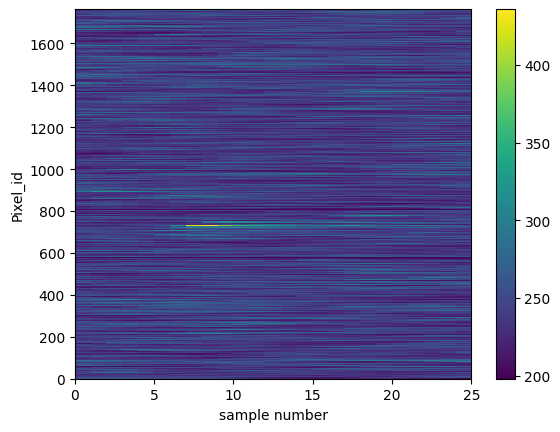

In [14]:
plt.pcolormesh(teldata.waveform[0])  # note the [0] is for channel 0
plt.colorbar()
plt.xlabel("sample number")
plt.ylabel("Pixel_id")

Let's zoom in to see if we can identify the pixels that have the Cherenkov signal in them

waveform[0] is an array of shape (N_pix,N_slice) = (1764, 25)


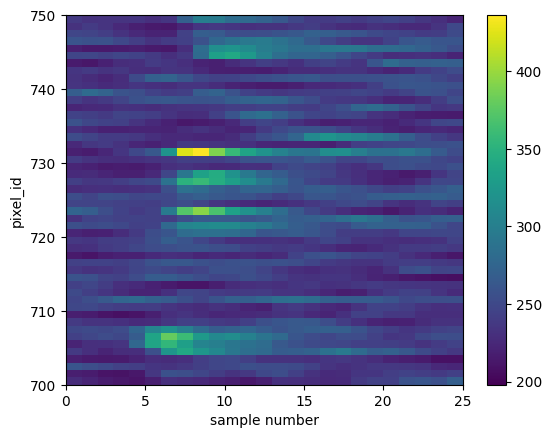

In [15]:
plt.pcolormesh(teldata.waveform[0])
plt.colorbar()
plt.ylim(700,750)
plt.xlabel("sample number")
plt.ylabel("pixel_id")
print("waveform[0] is an array of shape (N_pix,N_slice) =",teldata.waveform[0].shape)

Now we can really see that some pixels have a signal in them!

Lets look at a 1D plot of pixel 270 in channel 0 and see the signal:

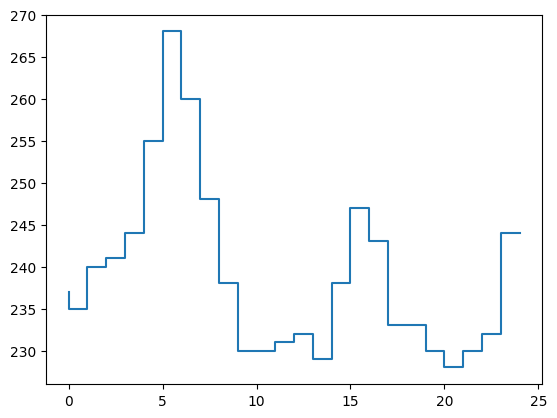

In [16]:
trace = teldata.waveform[0][719]   
plt.plot(trace, drawstyle='steps')

Great! It looks like a *standard Cherenkov signal*!

Let's take a look at several traces to see if the peaks area aligned:

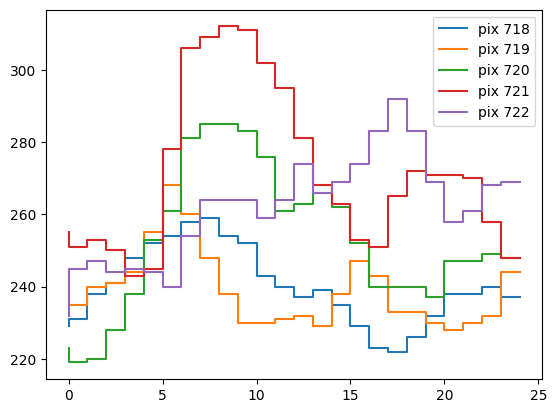

In [17]:
for pix_id in range(718,723):
    plt.plot(teldata.waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
plt.legend()

## Look at the time trace from a Camera Pixel

`ctapipe.calib.camera` includes classes for doing automatic trace integration with many methods, but before using that, let's just try to do something simple!

Let's define the integration windows first:
By eye, they seem to be reaonsable from sample 8 to 13 for signal, and 20 to 29 for pedestal (which we define as the sum of all noise: NSB + electronic)

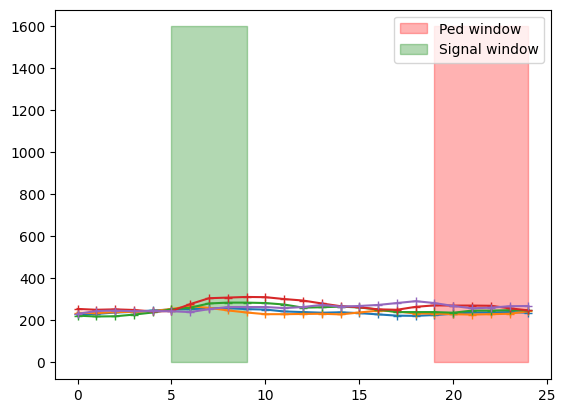

In [18]:
for pix_id in range(718,723):
    plt.plot(teldata.waveform[0][pix_id],'+-')
plt.fill_betweenx([0,1600],19,24,color='red',alpha=0.3, label='Ped window')
plt.fill_betweenx([0,1600],5,9,color='green',alpha=0.3, label='Signal window')
plt.legend()

## Do a very simplisitic trace analysis 
Now, let's for example calculate a signal and background in a the fixed windows we defined for this single event.  Note we are ignoring the fact that cameras have 2 gains, and just using a single gain (channel 0, which is the high-gain channel):

In [19]:
data = teldata.waveform[0]
peds = data[:, 19:24].mean(axis=1)  # mean of samples 20 to 29 for all pixels
sums = data[:, 5:9].sum(axis=1)/(13-8)    # simple sum integration

Text(0.5, 1.0, 'Pedestal Distribution of all pixels for a single event')

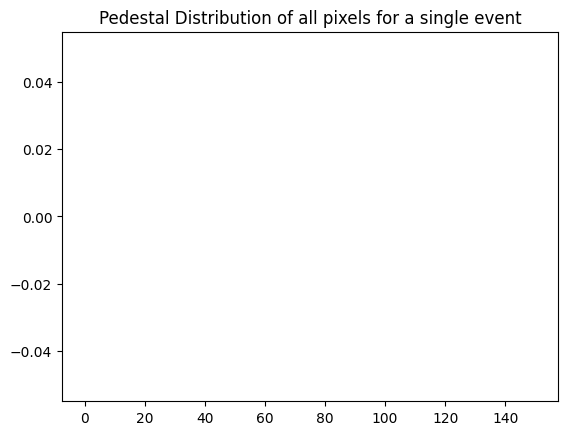

In [20]:
phist = plt.hist(peds, bins=50, range=[0,150])
plt.title("Pedestal Distribution of all pixels for a single event")

let's now take a look at the pedestal-subtracted sums and a pedestal-subtracted signal:


Text(0, 0.5, 'Pedestal-subtracted Signal')

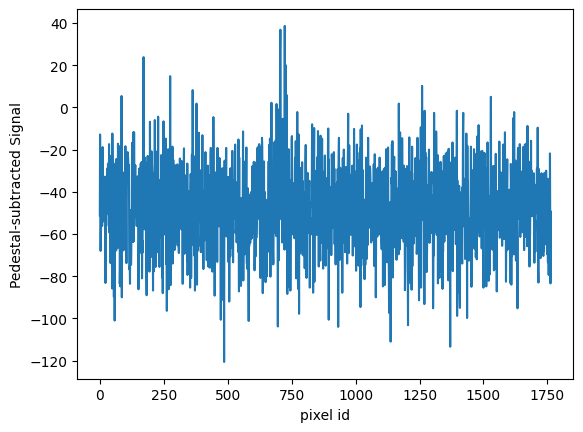

In [21]:
plt.plot(sums - peds)
plt.xlabel("pixel id")
plt.ylabel("Pedestal-subtracted Signal")

Now, we can clearly see that the signal is centered at 0 where there is no Cherenkov light, and we can also clearly see the shower around pixel 250.

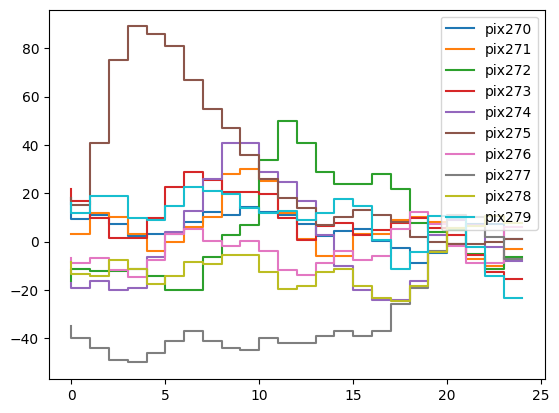

In [22]:
# we can also subtract the pedestals from the traces themselves, which would be needed to compare peaks properly
for ii in range(270,280):
    plt.plot(data[ii] - peds[ii], drawstyle='steps', label="pix{}".format(ii))
plt.legend()

## Camera Displays

It's of course much easier to see the signal if we plot it in 2D with correct pixel positions! 

>note: the instrument data model is not fully implemented, so there is not a good way to load all the camera information (right now it is hacked into the `inst` sub-container that is read from the Monte-Carlo file)

In [23]:
camgeom = source.subarray.tel[24].camera.geometry

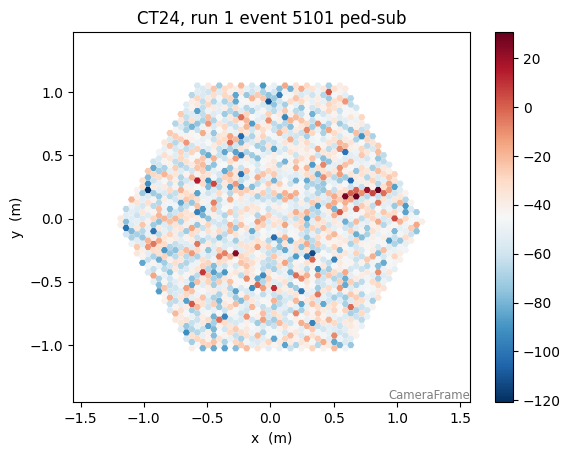

In [24]:
title="CT24, run {} event {} ped-sub".format(event.index.obs_id,event.index.event_id)
disp = CameraDisplay(camgeom,title=title)
disp.image = sums - peds 
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)  # autoscale

It looks like a nice signal! We have plotted our pedestal-subtracted trace integral, and see the shower clearly!

Let's look at all telescopes:

> note we plot here the raw signal, since we have not calculated the pedestals for each)

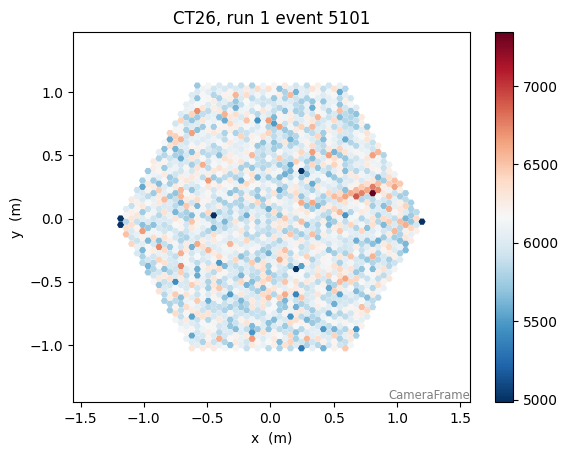

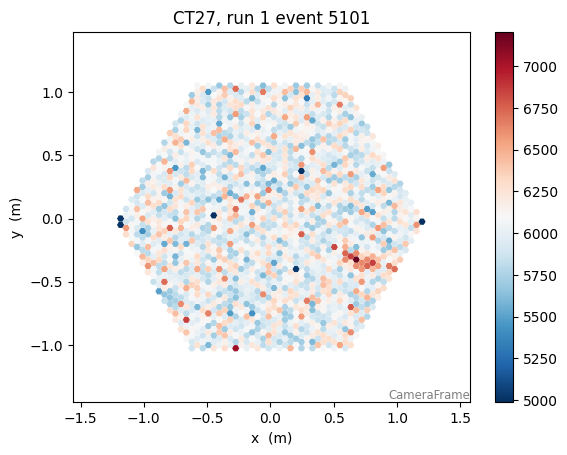

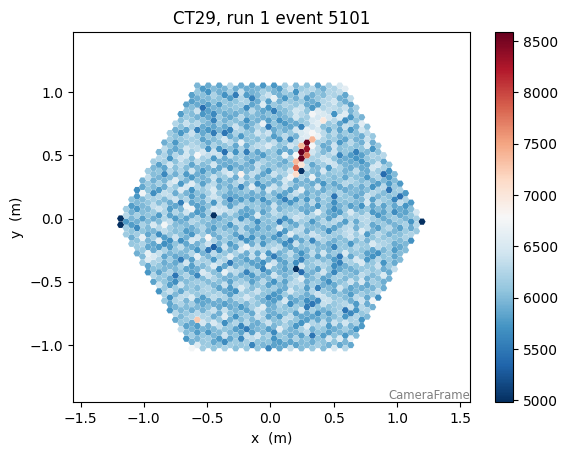

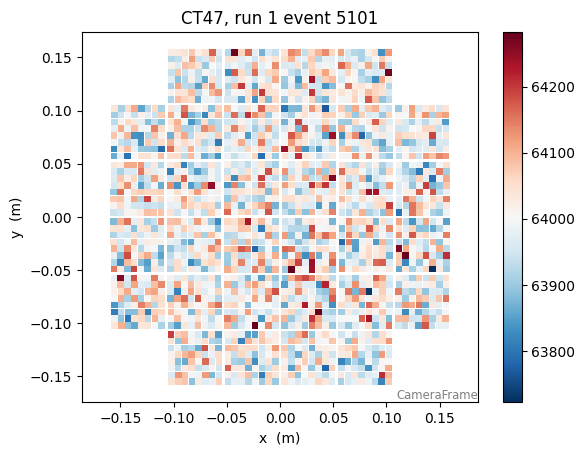

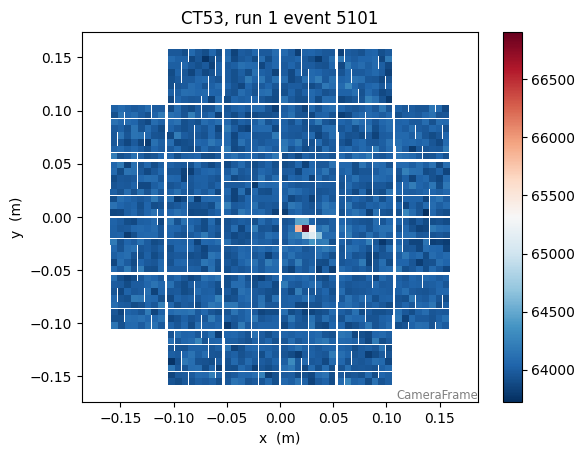

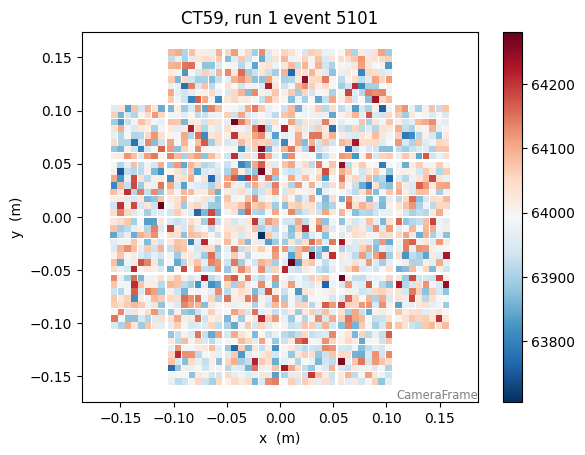

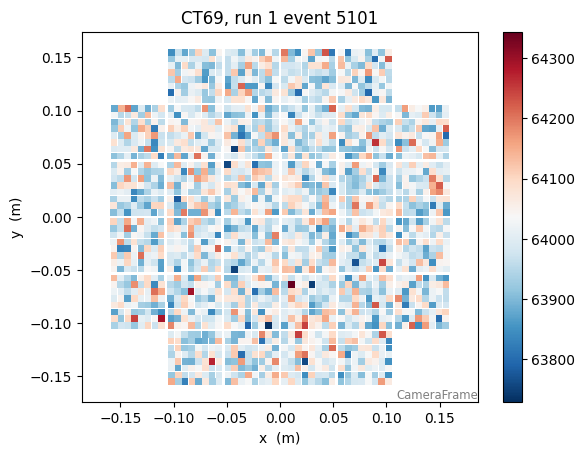

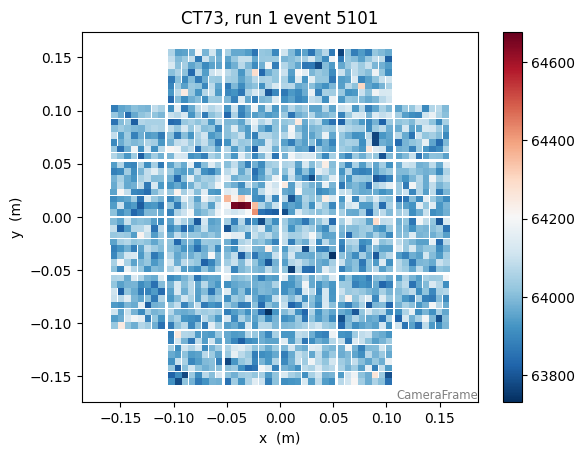

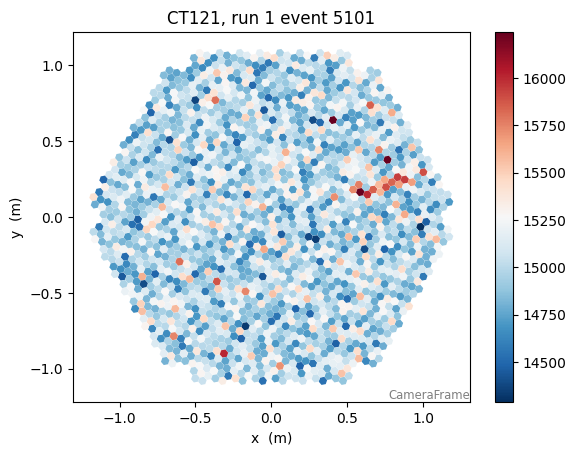

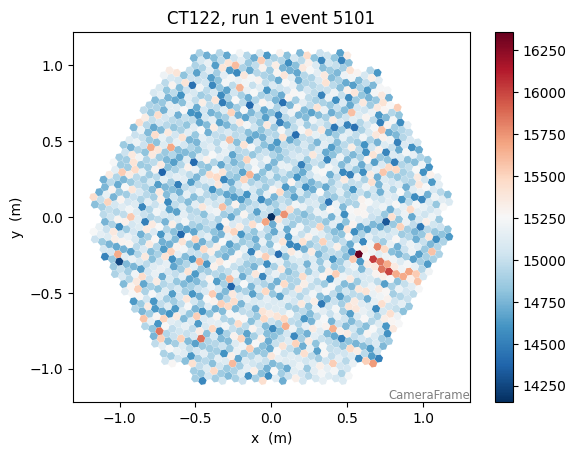

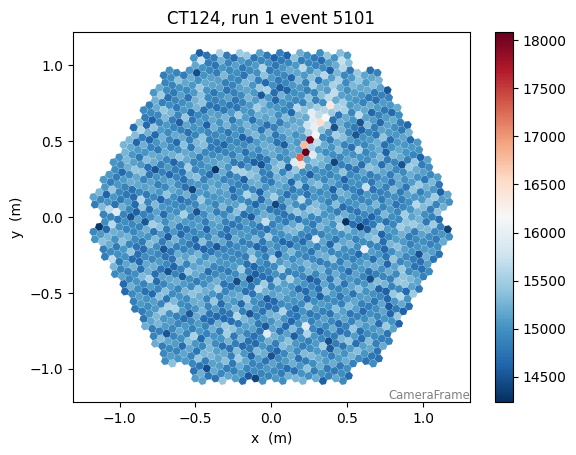

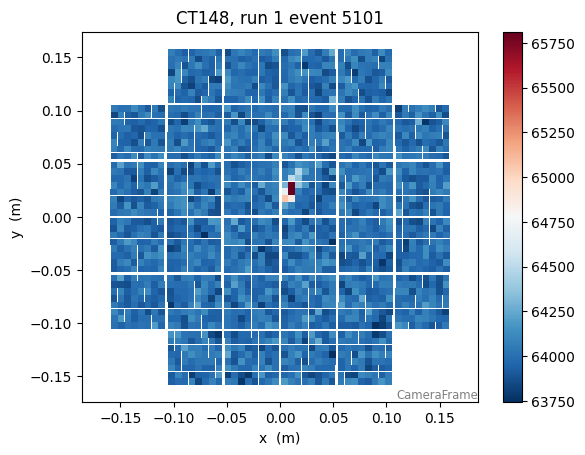

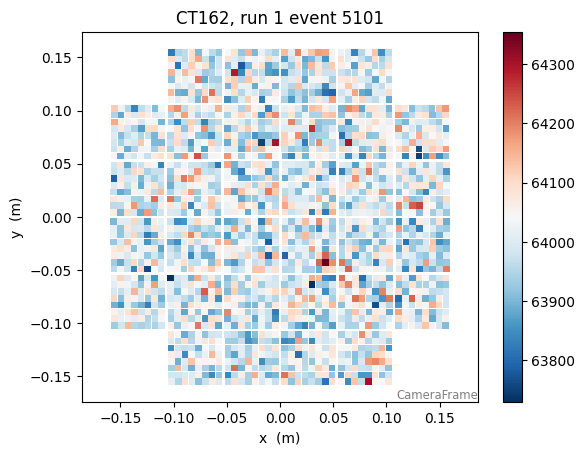

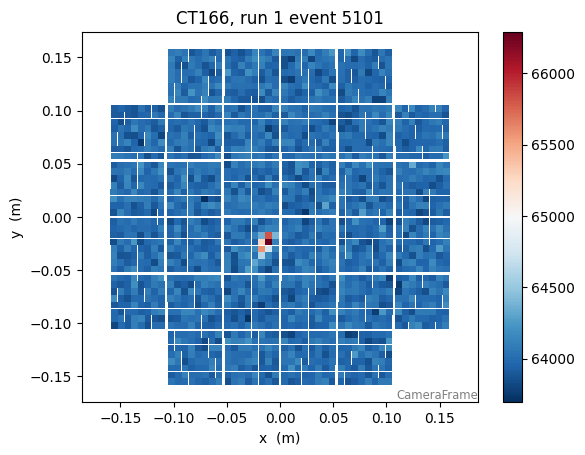

In [25]:
for tel in event.r0.tel.keys():
    plt.figure()
    camgeom = source.subarray.tel[tel].camera.geometry
    title="CT{}, run {} event {}".format(tel,event.index.obs_id,event.index.event_id)
    disp = CameraDisplay(camgeom,title=title)
    disp.image = event.r0.tel[tel].waveform[0].sum(axis=1)
    disp.cmap = plt.cm.RdBu_r
    disp.add_colorbar()
    disp.set_limits_percent(95)

## some signal processing...

Let's try to detect the peak using the scipy.signal package:
https://docs.scipy.org/doc/scipy/reference/signal.html

In [26]:
from scipy import signal
import numpy as np

In [27]:
pix_ids = np.arange(len(data))
has_signal = sums > 300

widths = np.array([8,]) # peak widths to search for (let's fix it at 8 samples, about the width of the peak)
peaks = [signal.find_peaks_cwt(trace,widths) for trace in data[has_signal] ]

for p,s in zip(pix_ids[has_signal],peaks):
    print("pix{} has peaks at sample {}".format(p,s))
    plt.plot(data[p], drawstyle='steps-mid')
    plt.scatter(np.array(s),data[p,s])

clearly the signal needs to be filtered first, or an appropriate wavelet used, but the idea is nice